# That one time I used linear regression for UI development

Gabriel Fouasnon <<gabriel@fouasnon.com>>

September 16, 2021

For my first Jupyter notebook, I decided to redo something I recently did in Apple Numbers.

I'm a frontend React/JavaScript engineer. Recently, I worked on a "get out the vote" web site with a friend in Germany. The designer working on the project gave us a series of wireframes for the web site. One of the wireframes presented a carousel. Site visitors could swipe left and right on the carousel to choose from one of five different messages. Once they chose a message they could then share it with their friends. 

After doing a web search and playing around with various third-party carousel modules, I chose to use Pure React Carousel: https://github.com/express-labs/pure-react-carousel. It seemed to be the least intrusive, most minimal carousel out there. Plus, our web site was written in React, so it made sense.

Here's one of the issues I encountered with Pure React Carousel. It requires you to set an aspect ratio for the carousel slides upfront, like so:

```jsx
<CarouselProvider
  naturalSlideWidth={16}
  naturalSlideHeight={9}
>
```

You might call the above example an HDTV carousel since it would set all of the slides to have a widescreen 16:9 (width:height) aspect ratio.

Our problem with having to set the aspect ratio in advance is that we weren't using photos (whose heights and widths are fixed in advance); we were using text paragraphs, and as you know, a paragraph gets taller the skinnier you make it. For example:

```
# Wide, short paragraph:
The quick brown fox jumped over the lazy dog.

# Skinny, 
# tall 
# paragraph:
The quick
brown fox
jumped over
the lazy 
dog.
```

So here's what I did.

I loaded our web site on three different devices (a laptop, a phone, and an even skinnier phone). I then measured the height of the tallest paragraph against the width of our main content column. (By the way, in order to do that quickly and efficiently, I used the device toolbar feature in Chrome Dev Tools. See https://developer.chrome.com/docs/devtools/device-mode/#viewport for more information.)

From playing around, I knew that the carousel module did not need extremely high precision with the aspect ratio. It just needed to be roughly close to the aspect ratio of the rendered text. So I figured I could just do a simple linear regression on the (width, height) data points.

At this point, I used the `LINEST` function in Apple Numbers to do a simple linear regression on my three data points. In Numbers, I got the following formula:

```
y = -1.966x + 1524
```

where `y` represents the __height__ of text/message height, and `x` represents the __width__ of the main content column.

For my first Jupyter notebook, I decided to try to do the same thing that I did in Apple Numbers. I did a [DuckDuckGo search](https://duckduckgo.com/?q=linear+regression.ipynb) and found the following linear regression tutorial, which I used for this notebook:
https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

## Load in the data

The first thing we have to do is import the __pandas__ library, which gives us tools to load and plot our data.

In [1]:
# imports
import pandas as pd

Next we will use __pandas__ to load our data. Remember that width refers to the width of the main content column of our web site, and height is the height of the tallest message in our carousel of five messages.

In [2]:
data = pd.read_csv('./screen-ratios-x-y.csv', index_col="device")
data.head()

,width,height
device,,
laptop,547,457
iphone x,375,750
iphone se,320,922


Next we use __pandas__ to visualize our three data points on a graph.

<AxesSubplot:xlabel='width', ylabel='height'>

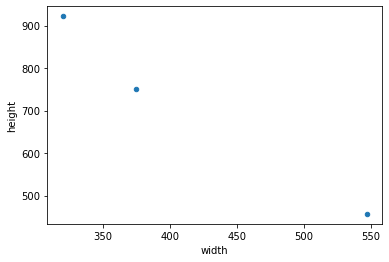

In [3]:
# visualize the relationship between the features and the response using scatterplots
data.plot(kind='scatter', x='width', y='height')

## Find the best fit line

We will use the __statsmodels__ library to do a linear regression—i.e., finding the best fit line through our three points.

In [4]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='height ~ width', data=data).fit()

# print the coefficients
lm.params

Intercept    1523.569469
width          -1.965949
dtype: float64

Notice that these two numbers are the same that Apple Numbers produced—the same x-coefficient (slope=-1.966) and the same y-intercept (=1524):

```
y = -1.966x + 1524
```

Now let's use the __matplotlibs__ library to plot our line and our data side-by-side, just to visually check our work.

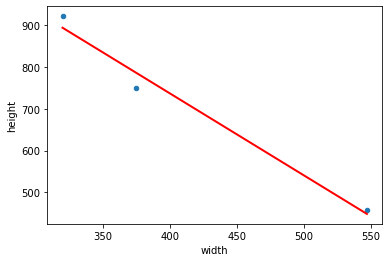

In [5]:
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

widths = pd.DataFrame({'width': [data.width.min(), data.width.max()]})
predicted_heights = lm.predict(widths)

# first, plot the observed data
data.plot(kind='scatter', x='width', y='height')

# then, plot the least squares line
plt.plot(widths, predicted_heights, c='red', linewidth=2)

## Conclusion

The best fit line doesn't perfectly fit the data points, but as I mentioned, based on my experience of playing around with the carousel module, we just needed the aspect ratio to be approximately correct. 

This allowed me to solve the issue we were having. As soon as the page loads, my code gets the width of the main column and then plugs that width into the equation we found above. In code, it looks something like this:

```jsx
const { width } = mainDiv.getBoundingClientRect();
const height = -1.966 * width + 1524;
return (
  <CarouselProvider
    naturalSlideWidth={width}
    naturalSlideHeight={height}
  >
  //  ...
)
```

Note that for the sake of simplicity, I omitted the fact that we had a max-width on our main content (div) block. So the above only applied when the width of the page fell below our max-width.